This notebook contains some tests to decide on an experimental design for the simulatability experiment.

In [1]:
import krippendorff


In [2]:
from scipy.stats import ttest_ind

In [3]:

import numpy as np 
import scipy.stats as stats 
import matplotlib.pyplot as plt


In [4]:
import pandas as pd
import numpy as np

In [5]:
import random

## Hase et al. 2020.

This is a within-subject* design with 4 phases: (1) Predictions only, (2) Pre-learn test, (3) Teaching: Predictions + Explanations, (4) Eval.

Phase 1 and 3 share a set of documents as do 2 and 4.

Result: Report **average change** in user accuracy per explanation method (phase 2 vs. 4), CI and p values of mean

Additional parameters in Hase et al.:
- Balance data "by model correctness" so random guessing can't succeed: *"we ensure that true positives, false positives,
true negatives, and false negatives are equally represented in the inputs. [...] We confirm user understanding of the data
balancing in our screening test"*
- Forced choice, to not "favor overly niche explanations" (like in Ribeiro et al.)
- Separate teach and test phases
- Pre prediction phase to obtain a baseline
- **All users see the same examples**


*: One explanation method per user, some users repeat the experiment with a new dataset!?!



### Feasability

In [6]:
columns_experiment = ["user_id", "document_id", "user_label"]


In [7]:
def guess(detector_label,p):
    return detector_label if bool(np.random.choice([0,1],p=[1-p, p])) else ~detector_label

In [8]:
def user_metrics(user_df, df_detector_output):
    df = user_df.join(df_detector_output, on="document_id")

   # display(df)
    TP = ((df["detector_label"]) & (df["user_label"])).sum()
    FP = ((~df["detector_label"]) & (df["user_label"])).sum()

    TN = ((~df["detector_label"]) & (~df["user_label"])).sum()
    FN = ((df["detector_label"]) & (~df["user_label"])).sum()

    acc = (TP+TN) / (TP+FP+TN+FN)
    # print("acc", acc)
    # print("TP", TP)
    # print("FP", FP)
    # print("TN", TN)
    # print("FN", FN)


    assert sum([TP,FP,TN,FN]) == len(df), "Check that input is bool"
    assert (acc ==(df["user_label"] == df["detector_label"]).sum() / len(df)), "Check that input is bool: acc"

    return pd.DataFrame([(TP,TN,FP,FN, acc)], columns=["TP","TN","FP","FN", "User Accuracy"])

In [9]:
def evaluate_user_study(df_detector_output, df_pre, df_eval):
    # "Reproducing" information from Table 1/2 in Hase et al.:
    user_metrics_pre = df_pre.groupby(["user_id"]).apply(lambda x : user_metrics(x,df_detector_output))

    user_metrics_eval = df_eval.groupby(["user_id"]).apply(lambda x : user_metrics(x,df_detector_output)) # TODO
    df_change = user_metrics_eval - user_metrics_pre
    df_change = df_change.rename(columns={"User Accuracy": "Change in User Accuracy"})

    user_acc_col = df_change["Change in User Accuracy"] # for convenience

    # use student t for low number of samples
    lower, upper = stats.t.interval(
    confidence=0.95, 
    df=len(user_acc_col)-1, # degrees of freedom = # samples - 1 for mean
              loc=user_acc_col.mean(), 
              scale=stats.sem(user_acc_col)
              ) 
    
    p_val = ttest_ind(user_metrics_eval["User Accuracy"],user_metrics_pre["User Accuracy"]).pvalue

    k_alpha = krippendorff.alpha(reliability_data=df_eval.groupby(["user_id"]).apply(lambda df : df["user_label"].astype(int).to_list()).to_list())



    lower_b, upper_b = stats.bootstrap((user_acc_col,), np.mean, confidence_level=0.95,).confidence_interval
    
    # print results
  #  print("Mean change in acc",user_acc_col.mean())
   # print("CI for mean change: [{},{}]".format(lower,upper))

##    print("CI by bootstrap: [{},{}]".format(lower_b, upper_b))

    
  #  print("p=%.10f" % p_val, "significant (< 0.05)" if p_val < 0.05 else "NOT significant (> 0.05)")
 #   print("Krippendorff between users: {}".format(k_alpha))
    return p_val
    

In [10]:
def mock_user_responses(df_detector_output, documents_pre_eval, users):
    responses_pre = []
    responses_eval = []
    # Phase 1: "16 examples from the validation set with labels and model predictions but no explanations"
    # Phase 2: "Then they must predict the model output for either 16 or 32 new inputs, with the number chosen based on user time constraints."
    for user_id, p_got_it_right_without,_ in users:
        responses_pre += [(user_id, document_id, guess(df_detector_output.loc[document_id]["detector_label"], p_got_it_right_without)) for document_id in documents_pre_eval]
    # Phase 3: " Next, they return to the same learning examples, now with explanations included."
    # Phase 4: " Finally, they predict model behavior again on the same instances from the first prediction round"
    for user_id, _,p_got_it_right_with in users:
        responses_eval += [(user_id, document_id,guess(df_detector_output.loc[document_id]["detector_label"], p_got_it_right_with)) for document_id in documents_pre_eval]
    return responses_pre, responses_eval

In [11]:

def mock_detector_responses(documents_pre_eval):
    df_detector_output = pd.DataFrame([(document_id, bool(random.randint(0,1)), bool(random.randint(0,1))) for document_id in documents_pre_eval], columns=["document_id", "detector_label","gold_label"])
    df_detector_output= df_detector_output.set_index("document_id")
    return df_detector_output

(array([ 13.,  42., 103., 140., 211., 216., 144.,  88.,  30.,  13.]),
 array([-0.17655307, -0.12094699, -0.0653409 , -0.00973481,  0.04587128,
         0.10147736,  0.15708345,  0.21268954,  0.26829563,  0.32390171,
         0.3795078 ]),
 <BarContainer object of 10 artists>)

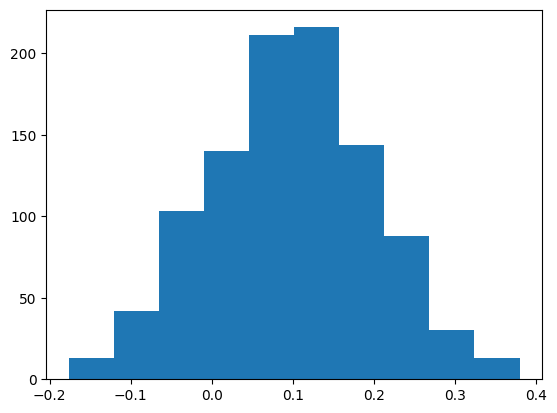

In [12]:
plt.hist(np.clip(np.random.normal(0.1, 0.1, 1000),-1,1))

In [13]:
def simulate_hase(

        n_learn = 16,
        n_eval = 16,
        n_users = 10,

        mu_got_it_right_pre=0.5,
        sigma_got_it_right_pre=0.05,

        mu_gain = 0.1,
        sigma_gain = 0.1,


):
    users = []
    user_dist_without = lambda : np.clip(np.random.normal(mu_got_it_right_pre, sigma_got_it_right_pre, 1)[0], 0,1)
    user_dist_gain = lambda : np.clip(np.random.normal(mu_gain, sigma_gain, 1)[0], -1,1)
    for i in range(1, n_users+1):
        p_without = user_dist_without()
        p_with = np.clip(p_without + user_dist_gain(), 0,1)
        users.append(("u_%s" % i, p_without ,p_with))
    documents_learn_1_2 = ["l_%s" % i for i in range(1,n_learn+1)]
    documents_pre_eval = ["e_%s" % i for i in range(1,n_eval+1)]

    df_detector_output = mock_detector_responses(documents_pre_eval)

    responses_pre, responses_eval = mock_user_responses(df_detector_output, documents_pre_eval, users)
    df_pre =pd.DataFrame(responses_pre, columns=columns_experiment)
    df_eval =pd.DataFrame(responses_eval, columns=columns_experiment)

 #   print("# responses pre", len(responses_pre))
  #  print("# responses pre per method", len(responses_pre)/3)
   # print("Each user saw {} instances. ".format(2*n_learn + 2*n_eval) )
   # print("Used {} unique documents. A set of {} in phase 1 and 3; and a set of {} in phase 2 and 4.".format(n_learn + n_eval,n_learn, n_eval))

#    print("Results based on {} unique eval documents.".format(n_eval))

#    print("Results based on {} datapoints.".format(len(responses_eval)))
    p_value = evaluate_user_study(df_detector_output, df_pre, df_eval)
    return p_value

In [14]:
simulate_hase()

0.23944658813842495

## Vary p_gain

In [15]:
pip install seaborn

   ---------------------------------------- 0.0/294.8 kB ? eta -:--:--
   ----------- ---------------------------- 81.9/294.8 kB 2.3 MB/s eta 0:00:01
   ---------------------------------- ----- 256.0/294.8 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 294.8/294.8 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import seaborn as sns

In [1]:
(30*20)/3

200.0

: 

In [25]:
n_users = 33
p_values = []
for _ in range(0,100):
    mu_gain_ = np.arange(-0.5,0.5, 0.05)
    for mu_gain in mu_gain_:
        if mu_gain == 0:
            continue
        p_values.append((mu_gain, simulate_hase(
            n_learn = 20,
            n_eval = 20,
            n_users = n_users//3,

            mu_got_it_right_pre=0.5,
            sigma_got_it_right_pre=0.1,

            mu_gain = mu_gain,
            sigma_gain = 0.01,
            )))
df = pd.DataFrame(p_values)


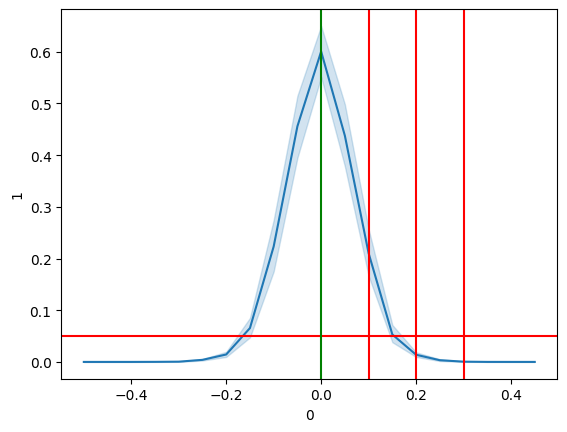

In [26]:
sns.lineplot(data=df, x=0, y=1)
plt.axhline(y=0.05, color="red")
plt.axvline(x=0.1, color="red")
plt.axvline(x=0.0, color="green")
plt.axvline(x=0.2, color="red")
plt.axvline(x=0.3, color="red")

In [19]:
results

NameError: name 'results' is not defined

6


c:\Users\loris\thesis\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\loris\thesis\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\Users\loris\thesis\.venv\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
c:\Users\loris\thesis\.venv\Lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))
c:\Users\loris\thesis\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellatio

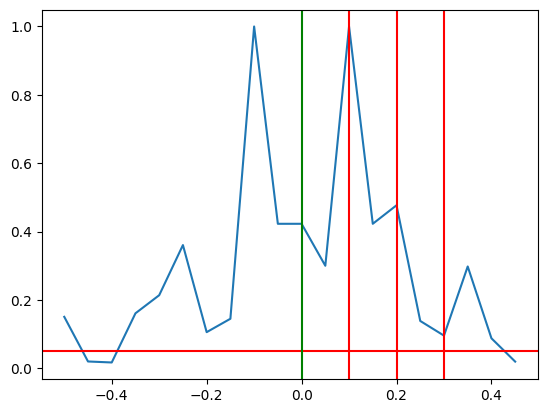

9


c:\Users\loris\thesis\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


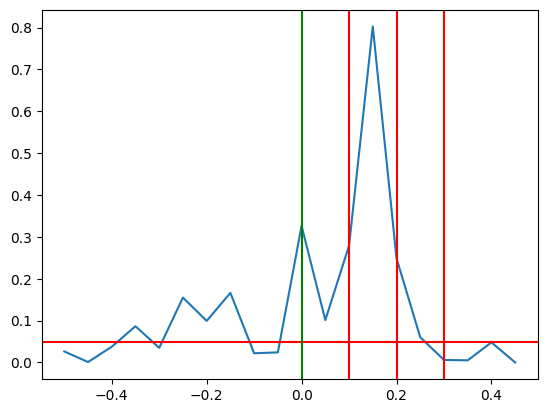

12


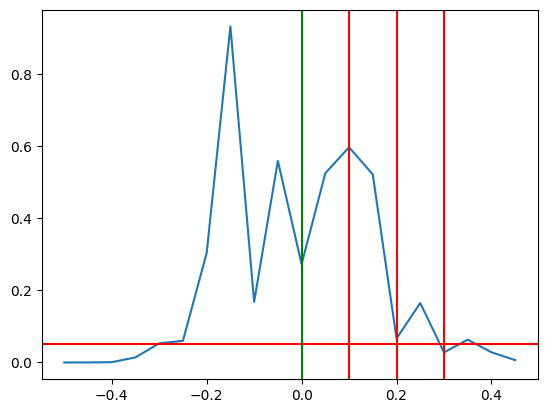

15


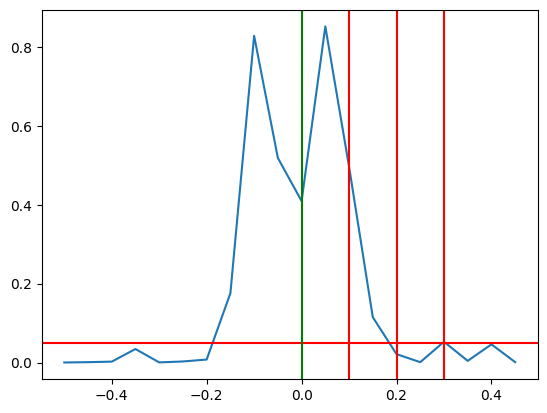

18


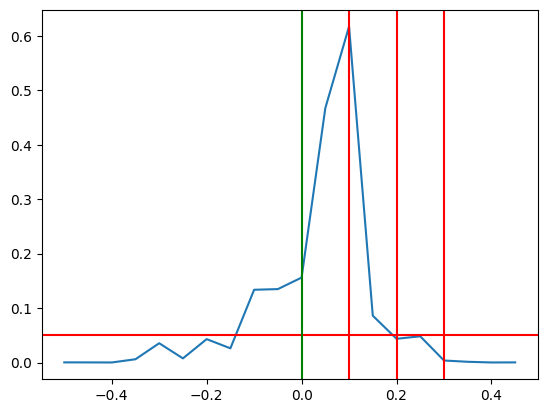

21


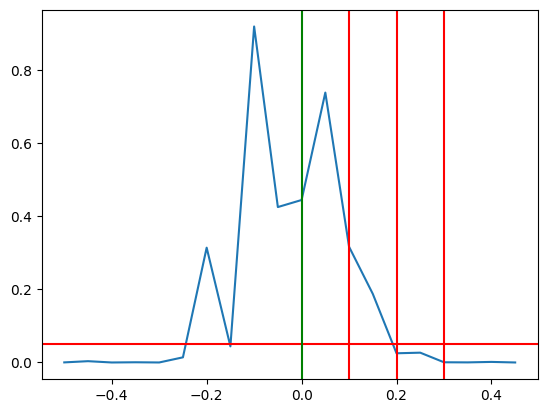

24


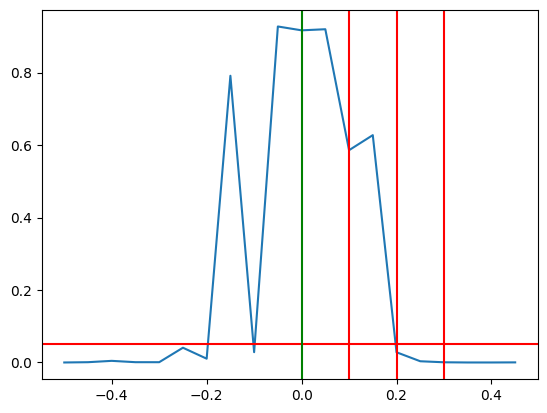

27


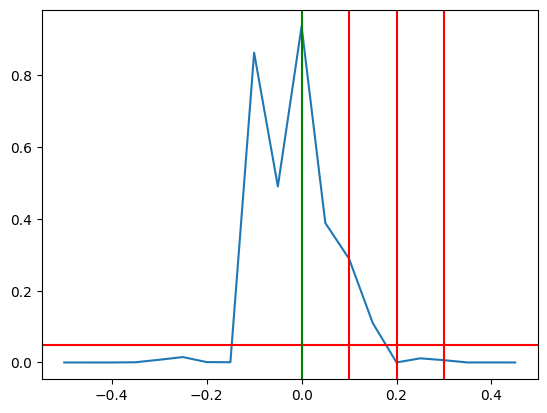

30


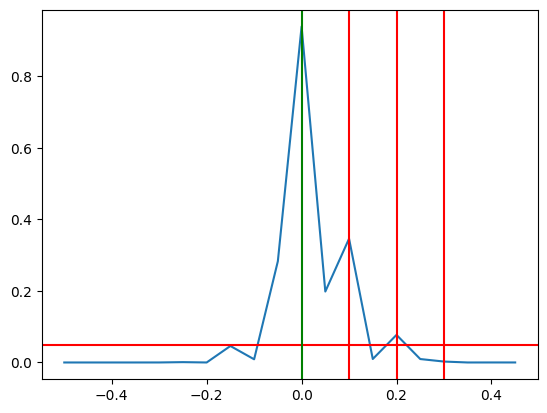

33


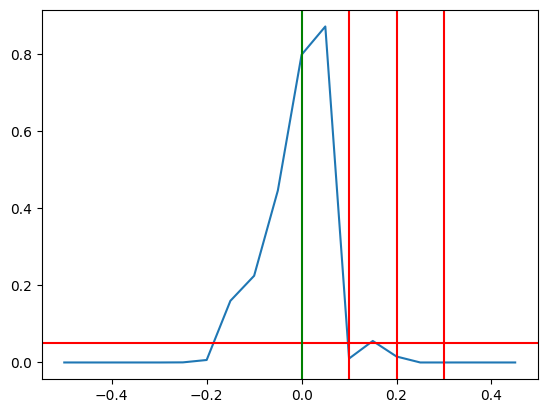

36


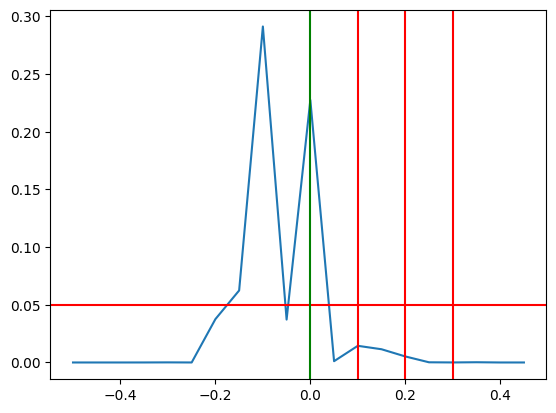

39


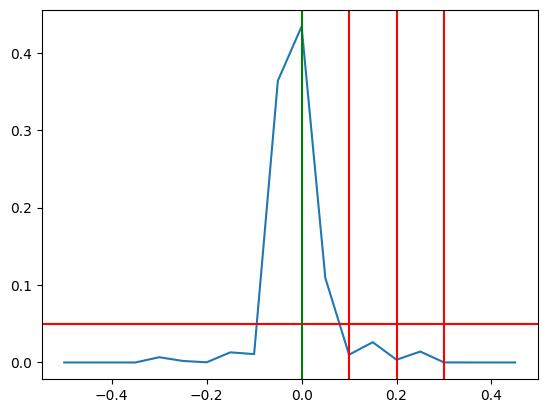

42


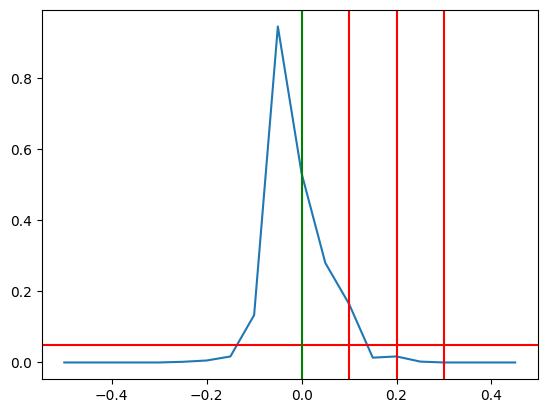

45


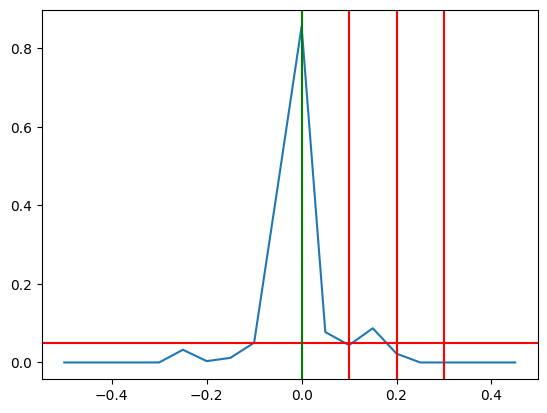

48


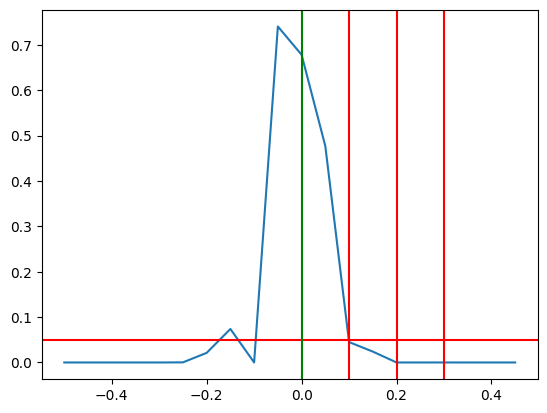

51


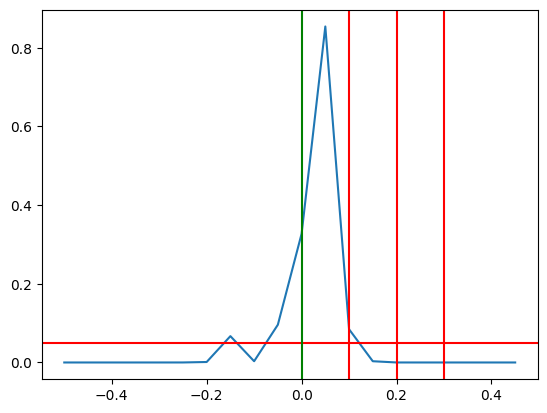

54


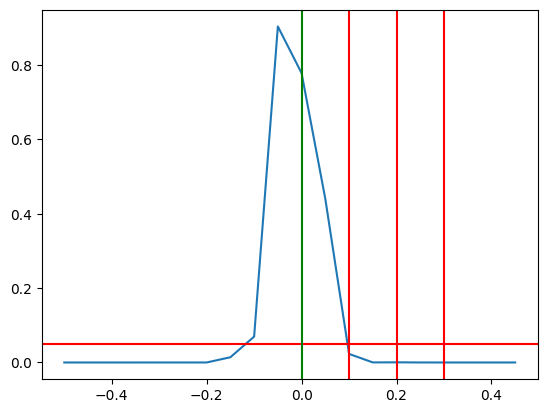

57


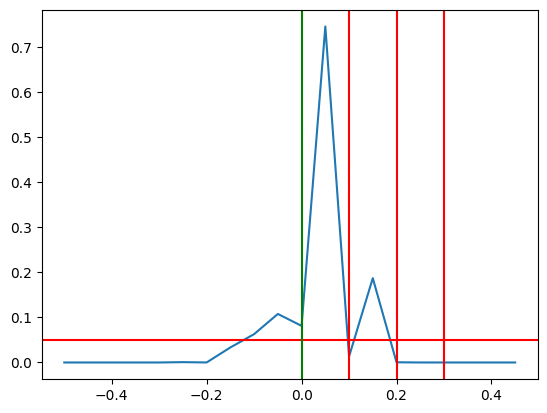

In [ ]:
n_users_ = list(range(6,60,1))
for n_users in n_users_:
    if n_users % 3:
        continue
    print(n_users)
    p_values = []
    mu_gain_ = np.arange(-0.5,0.5, 0.05)
    for mu_gain in mu_gain_:
        if mu_gain == 0:
            continue
        p_values.append(simulate_hase(
            n_learn = 16,
            n_eval = 16,
            n_users = n_users//3,

            mu_got_it_right_pre=0.5,
            sigma_got_it_right_pre=0.1,

            mu_gain = mu_gain,
            sigma_gain = 0.01,
            ))
    plt.plot(mu_gain_, p_values)
    plt.axhline(y=0.05, color="red")
    plt.axvline(x=0.1, color="red")
    plt.axvline(x=0.0, color="green")
    plt.axvline(x=0.2, color="red")
    plt.axvline(x=0.3, color="red")
    plt.show()
    

## Vary num of users

In [ ]:
p_values = []
n_users_ = list(range(2,50))
for n_users in n_users_:
    p_values.append(simulate_hase(
        n_learn = 16,
        n_eval = 16,
        n_users = n_users,
        ))
    

c:\Users\loris\thesis\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\loris\thesis\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\Users\loris\thesis\.venv\Lib\site-packages\scipy\stats\_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
c:\Users\loris\thesis\.venv\Lib\site-packages\scipy\stats\_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


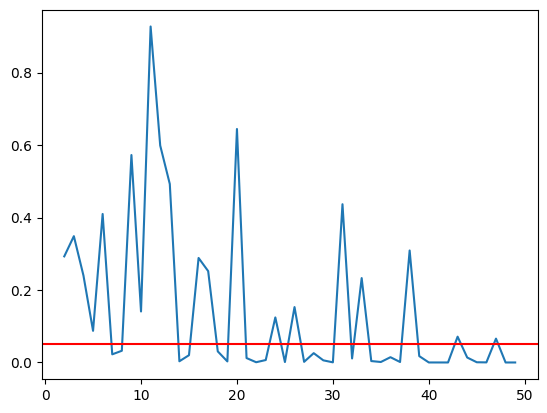

In [ ]:
plt.plot(n_users_, p_values)
plt.axhline(y=0.05, color="red")